## Project 7: Self-supervised single-image depth-estimation using neural-networks

### Authors:
#### ◘ Sharhad Bashar
#### ◘ Lizhe Chen
#### ◘ Genséric Ghiro
#### ◘ Futian Zhang

## 1) Abstract: In a few short sentences highlighting the main points of the project.

The main disadvantage of supervised learning is that we need to know the ground truth dense depth value corresponding to 
a large number of input pictures in advance as the constraint of training. We need expensive LiDAR Equipment to find the depth of monocular, but we can set up two cameras on the same horizontal line easily (save the expense). If we can predict the disparity from one single image, the actual depth can be calculated by disparity and the camera parameters. We can train a disparity prediction network which taking left image as an input and use the right image reconstruction error as the loss function to back propagate the network. 

## 2) Introduction (3-4 paragraphs): reviewing your topic, related technical ideas/algorithms, your selected methodology/approach, its motivation)

2. Dataset:

Small dataset: investigate how network performance has been decreased with small dataset.

Use KITTI dataset, a popular, large driving dataset:

1. KITTI dataset has left & right images for each scene

2. Most of the scene has large depth range (close distance to infinity depth) on a long depth axis.

3. Commonly used by SOTA algorithms.

4. Also has the LiDAR ground truth to evaluate our self-supervised network.

-	Use manually selected images for validation and evaluation, 500 pairs. This dataset  serves as a benchmark for Depth Prediction and Depth Completion (Sparse to Dense)(http://www.cvlibs.net/download.php?file=data_depth_selection.zip) 
-	The original training set has 93K pairs, but we only select 5800 pairs of the images from the drives on 2011 September 26th which are not included in the validation dataset as the training dataset. 
-	We only use the Random Flip strategy for Data Augmentation. Since we are using Binocular image pairs to train a monocular depth predictor, we need to swap the left and right images if we flip them. (We may talk about why color augmentation failed. )

Data part: 

The kitti dataset was downloaded from http://www.cvlibs.net/download.php?file=data_depth_selection.zip. We unzipped them and used the python script “dataCreator.py” to convert PNG files to JPG files in order to reduce the file size. There are 5882 pairs of Left and Right pictures for training and 500 pairs for validation.

Dataloader(5a) was used to load the jpg files to tensor in PyTorch. In the class TwoViewDataset, it receives data path, resize shape, a flag to identify training or validating, transforms for data augmentation, sanity check flag to perform overfitting condition, and color mode setting string to convert the data to RGB or grayscale. It reads the corresponding data from training or validation path. In the getitem method, we first read the pictures and convert them to the shape and color space passed from the init function. Then it will process the transforms. It could be some data augmentation or just to tensor directly. It will return the pairs of pictures after everything is done.

In the data augmentation part, we first create some classes as what we did in the Assignment 4. First, JointRandomFilp class random horizontally flips two pictures with a probability of 0.5. If the pair is flipped, then it will be swapped with each other to make sure that the relative position is still left and right. We also added JointRandomColorAug to augment the color to make the training more robust and avoid overfitting. It changes the gamma, brightness and saturate. We also implement JointToTensor and JointToImage to convert between PyTorch tensor and Pillow image. We reused JointCompose in A04 to convert the pair of pictures together.


3. Models (ResNet and VGG)

Model design:
In the original paper, they designed a 14- layers encoder to extract the features of the input and use a symmetric decoder with the skip connections from the encoder to produce a disparity pyramid for loss function calculation. We re-write the Resnet and VGG as encoders and create correspond decoders to investigate that whether this art of the design can be populated to other pretrained networks.  

For the complicate tasks like disparity prediction, we need deep neural network to extract the features. However, with the deepening of the network, the accuracy of the training set may decrease. We can make sure that this is not caused by overfitting since the accuracy of the training set should be high in the case of over fitting. One hypothesis is that the gradient decent signals backpropagated from the later layers to the early layers are attenuated when they pass through the layers.  So, we concatenate the input and output of certain layers as an input for later layers in order to fit a residual function and build short paths between early and later layers to update the top parameters properly. We use ResNet as our main backbone so the skip connection feature will be used in the encoder as well. Also, all of us used the pretrained ResNet as a starter in our assignment 4 and got decent results. We think we can treat the segmentation task as a combination of classification and depth detection (to separate the objects from background), we suppose ResNet would have good performance on this project as well.



<img src="vgg_model.png"> (vgg16 structure)

We used the pretrained VGG16_bn model from pytorch build-in model. VGG network used two layers 3*3 Kernels to replace one 5*5 Kernel in Alexnet to collect feature from the same part of 5*5 pixels, which makes the network deeper. VGG16_bn used batch norm to speed up the training and avoid the gradient vanishing problem and gradient exploding problem for such a deep network. We display the VGG16_bn model, and store the result at the beginning and before each pooling layer for skipping later. There are 5 skip layers in total. We only used the first 43 layers because we need to rebuild the right picture and layers later than are used to classification. The rest part of the network is the same as our Resnet model.

## 3) Contributions section: This section should have one separate short paragraph (or a bullet) dedicated to each co-author clearly indicating her/his specific contributions. 

#### Sharhad Bashar:
       •
       •
       •
       
#### Lizhe Chen:
       •
       •
       •
       
#### Genséric Ghiro:
       • Research papers reading
       • Helped in the design of the network
       • Redaction of the final report
       • Implemented the trainer
       
#### Futian Zhang:
       • Implement data loader to load the dataset.
       • Implement the data augmentation.
       • Tried to setup the project to Colab.
       • Implement VGG model for training.
       • Help integrate the project together.

## 4) Outline section: overall structure of the report

• 5aa) Imports: Loading librairies required to run the code

• 5a) Dataloader: Data augmentation and preparation of ground truth (only to compute a final error, not to train the model)

• 5b) Network: Two implementations, one with vgg16 as the encoder, and the other one with resnet18 as the encoder

• 5c) Validator: typical validation loop of neural networks 

• 5d) Trainer: typical training loop of neural networks 

• 5e) Training (the 2 models)

• 6) Results display: Graph of the validation error and sample of outputs for both networks

• 7) Conclusion: Discussing results 

• 8) References

## 5aa) Imports

In [1]:
%matplotlib inline

In [ ]:
# Before running this, make sure that loss.py is in the same folder as this file
# We did not include it here as part of the notebook, since it has been taken from [3] (see references) without modification
# and thus, it is not our own work
from loss import MonodepthLoss

In [2]:
from __future__ import absolute_import, division, print_function

import scipy
import skimage
from scipy.sparse.linalg import spsolve

import os
import glob
import random
import numpy as np
import copy
from PIL import Image 
import torch
import time
from matplotlib import pyplot as plt

#5a)
import torch.utils.data as data
from torchvision import transforms
import torchvision.transforms.functional as tF

#5b)
import torch.nn as nn
import torch.nn.functional as F
import importlib
import torchvision.models as models

#5c) 
import torch.optim as optim
from torch.utils.data import DataLoader

#5d)
import pickle

#5e)
from torch.utils.data.dataloader import *

## 5a) Dataloader

In [3]:
class JointRandomFlip(object):
    def __call__(self, L, R):
        if np.random.random_sample()>0.5:
            return (tF.hflip(R),tF.hflip(L))
        return (L,R)
       
class JointRandomColorAug(object):

    def __init__(self,gamma=(0.8,1.2),brightness=(0.5,2.0),color_shift=(0.8,1.2)):
        self.gamma = gamma
        self.brightness = brightness
        self.color_shift = color_shift

    def __call__(self, L, R):
        if  np.random.random_sample()>0.5:
            
            random_gamma = np.random.uniform(*self.gamma)
            L_aug = L ** random_gamma
            R_aug = R ** random_gamma

            random_brightness = np.random.uniform(*self.brightness)
            L_aug = L_aug * random_brightness
            R_aug = R_aug * random_brightness

            random_colors = np.random.uniform(self.color_shift[0],self.color_shift[1], 3)
            for i in range(3):
                L_aug[i, :, :] *= random_colors[i]
                R_aug[i, :, :] *= random_colors[i]

            # saturate
            L_aug = torch.clamp(L_aug, 0, 1)
            R_aug = torch.clamp(R_aug, 0, 1)

            return L_aug, R_aug

        else:
            return L, R

class JointToTensor(object):
    def __call__(self, L, R):
        return tF.to_tensor(L),tF.to_tensor(R)
    
class JointToImage(object):
    def __call__(self, L, R):
        return transforms.ToPILImage()(L),transforms.ToPILImage()(R)
    
    
class JointCompose(object):
    def __init__(self, transforms):
        """
        params: 
           transforms (list) : list of transforms
        """
        self.transforms = transforms

    # We override the __call__ function such that this class can be
    # called as a function i.e. JointCompose(transforms)(img, target)
    # Such classes are known as "functors"
    def __call__(self, img, target):
        """
        params:
            img (PIL.Image)    : input image
            target (PIL.Image) : ground truth label 
        """
        assert img.size == target.size
        for t in self.transforms:
            img, target = t(img, target)
        return img, target


class TwoViewDataset(data.Dataset):
    
    def __init__(self, 
                 data_path,
                 resize_shape=(512,256), 
                 is_train=False,
                 transforms=None,
                 sanity_check=None,
                 color='RGB'):
        super(TwoViewDataset, self).__init__()
        self.data_path = data_path

        self.interp = Image.ANTIALIAS
        self.resize_shape = resize_shape
        self.is_train = is_train
        self.transforms=transforms
        self.color = color
        
        if is_train:
            self.imgR_folder = os.path.join(data_path, "train", "image_right")
            self.imgL_folder = os.path.join(data_path, "train", "image_left")
        else:
            self.imgR_folder = os.path.join(data_path, "val", "image_right")
            self.imgL_folder = os.path.join(data_path, "val", "image_left")
        
        
        self.imgR=[os.path.join(self.imgR_folder, x) for x in os.listdir(self.imgR_folder)]
        self.imgL=[os.path.join(self.imgL_folder, x) for x in os.listdir(self.imgL_folder)]


    def __len__(self):
        return len(list(glob.glob1(self.imgL_folder, "*.jpg")))

    def __getitem__(self, index):
        #print(np.array(Image.open(self.imgR[index]).convert('RGB')).shape)
        colorR=Image.open(self.imgR[index]).convert(self.color).resize(self.resize_shape)
        colorL=Image.open(self.imgL[index]).convert(self.color).resize(self.resize_shape)
        #print(np.array(colorR).shape)
        
        if self.transforms is not None:
            colorR, colorL = self.transforms(colorR, colorL)
        return colorL, colorR


class GroundTruth(data.Dataset):
    def __init__(self, 
                 data_path,
                 resize_shape=(512,256), 
                 is_train=False,
                 transforms=JointToTensor(),
                 sanity_check=None):
        super(GroundTruth, self).__init__()
        self.data_path = data_path

        self.interp = Image.ANTIALIAS
        self.resize_shape = resize_shape
        self.is_train = is_train
        self.transforms=transforms
        self.loader = pil_loader
        
        self.imgR_folder = os.path.join(data_path, "val", "image_right")
        self.imgL_folder = os.path.join(data_path, "val", "image_left")
        self.gtR_folder = os.path.join(data_path, "val", "gt_right")
        self.gtL_folder = os.path.join(data_path, "val", "gt_left")
        
        self.imgR=[os.path.join(self.imgR_folder, x) for x in os.listdir(self.imgR_folder)]
        self.imgL=[os.path.join(self.imgL_folder, x) for x in os.listdir(self.imgL_folder)]
        self.gtR=[os.path.join(self.gtR_folder, x) for x in os.listdir(self.gtR_folder)]
        self.gtL=[os.path.join(self.gtL_folder, x) for x in os.listdir(self.gtL_folder)]

    def depth_read(self, filename):

        depth_png = np.array(Image.open(filename).resize(self.resize_shape), dtype=int)
        assert(np.max(depth_png) > 255)

        depth = depth_png.astype(np.float) / 256.
        depth[depth_png == 0] = -1.
        return depth


    def get_color(self, path, do_flip):
        color = self.loader(path)
        if do_flip:
            color = color.transpose(Image.FLIP_LEFT_RIGHT)
        return self.to_tensor(color)

    def depth_colorization(self, imgRgb=None, imgDepthInput=None, alpha=1):
        imgIsNoise = imgDepthInput == 0
        maxImgAbsDepth = np.max(imgDepthInput)
        imgDepth = imgDepthInput / maxImgAbsDepth
        imgDepth[imgDepth > 1] = 1
        (H, W) = imgDepth.shape
        numPix = H * W
        indsM = np.arange(numPix).reshape((W, H)).transpose()
        knownValMask = (imgIsNoise == False).astype(int)
        grayImg = skimage.color.rgb2gray(imgRgb)
        winRad = 1
        len_ = 0
        absImgNdx = 0
        len_window = (2 * winRad + 1) ** 2
        len_zeros = numPix * len_window

        cols = np.zeros(len_zeros) - 1
        rows = np.zeros(len_zeros) - 1
        vals = np.zeros(len_zeros) - 1
        gvals = np.zeros(len_window) - 1

        for j in range(W):
            for i in range(H):
                nWin = 0
                for ii in range(max(0, i - winRad), min(i + winRad + 1, H)):
                    for jj in range(max(0, j - winRad), min(j + winRad + 1, W)):
                        if ii == i and jj == j:
                            continue

                        rows[len_] = absImgNdx
                        cols[len_] = indsM[ii, jj]
                        gvals[nWin] = grayImg[ii, jj]

                        len_ = len_ + 1
                        nWin = nWin + 1

                curVal = grayImg[i, j]
                gvals[nWin] = curVal
                c_var = np.mean((gvals[:nWin + 1] - np.mean(gvals[:nWin+ 1])) ** 2)

                csig = c_var * 0.6
                mgv = np.min((gvals[:nWin] - curVal) ** 2)
                if csig < -mgv / np.log(0.01):
                    csig = -mgv / np.log(0.01)

                if csig < 2e-06:
                    csig = 2e-06

                gvals[:nWin] = np.exp(-(gvals[:nWin] - curVal) ** 2 / csig)
                gvals[:nWin] = gvals[:nWin] / sum(gvals[:nWin])
                vals[len_ - nWin:len_] = -gvals[:nWin]

                # Now the self-reference (along the diagonal).
                rows[len_] = absImgNdx
                cols[len_] = absImgNdx
                vals[len_] = 1  # sum(gvals(1:nWin))

                len_ = len_ + 1
                absImgNdx = absImgNdx + 1

        vals = vals[:len_]
        cols = cols[:len_]
        rows = rows[:len_]
        A = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

        rows = np.arange(0, numPix)
        cols = np.arange(0, numPix)
        vals = (knownValMask * alpha).transpose().reshape(numPix)
        G = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

        A = A + G
        b = np.multiply(vals.reshape(numPix), imgDepth.flatten('F'))

        #print ('Solving system..')

        new_vals = spsolve(A, b)
        new_vals = np.reshape(new_vals, (H, W), 'F')

        #print ('Done.')

        denoisedDepthImg = new_vals * maxImgAbsDepth
        
        output = denoisedDepthImg.reshape((H, W)).astype('float32')

        output = np.multiply(output, (1-knownValMask)) + imgDepthInput
        
        return output

    def __len__(self):
        return len(list(glob.glob1(self.imgL_folder, "*.jpg")))

    def __getitem__(self, index):
        #print(np.array(Image.open(self.imgR[index]).convert('RGB')).shape)
        colorR=Image.open(self.imgR[index]).convert('RGB').resize(self.resize_shape)
        colorL=Image.open(self.imgL[index]).convert('RGB').resize(self.resize_shape)
        #print(np.array(colorR).shape)
        gtR=self.depth_read(self.gtR[index])
        gtL=self.depth_read(self.gtL[index])


        colorR_N = np.array(colorR)/255.0
        colorL_N = np.array(colorL)/255.0


        gtR = self.depth_colorization(imgRgb=colorR_N, imgDepthInput=gtR, alpha=1)
        gtL = self.depth_colorization(imgRgb=colorL_N, imgDepthInput=gtL, alpha=1)
        
        # if self.transforms is not None:
        #     colorR, colorL = self.transforms(colorR, colorL)
        #     gtR, gtL = self.transforms(gtR, gtL)


        return gtL, gtR

## 5b) Network 1 (with Resnet18 as encoder) and Network 2 (with VGG16 as encoder)

In [4]:
class get_disp(nn.Module):
    def __init__(self, num_in_channels):
        super(get_disp, self).__init__()
        self.p2d = (1, 1, 1, 1)
        self.disp = nn.Sequential(nn.Conv2d(num_in_channels, 2, kernel_size=3, stride=1),
                                  nn.BatchNorm2d(2),
                                  torch.nn.Sigmoid())

    def forward(self, x):
        x = self.disp(F.pad(x, self.p2d))
        return 0.3 * x


class iconv(nn.Module):
    def __init__(self, num_in_channels, num_out_channels, kernel_size, stride):
        super(iconv, self).__init__()
        p = int(np.floor((kernel_size - 1) / 2))
        self.p2d = p2d = (p, p, p, p)

        self.iconv = nn.Sequential(nn.Conv2d(num_in_channels, num_out_channels, kernel_size=kernel_size, stride=stride),
                                  nn.BatchNorm2d(num_out_channels))

    def forward(self, x):
        x = self.iconv(F.pad(x, self.p2d))
        return F.elu(x, inplace=True)


class iconv_dilate(nn.Module):
    def __init__(self, num_in_channels, num_out_channels, kernel_size, stride, dilation):
        super(iconv, self).__init__()
        p = int(np.floor((kernel_size - 1) / 2))
        self.p2d = p2d = (p, p, p, p)

        self.iconv = nn.Sequential(nn.Conv2d(num_in_channels, num_out_channels, kernel_size=kernel_size, stride=stride, dilation=dilation),
                                  nn.BatchNorm2d(num_out_channels))

    def forward(self, x):
        x = self.iconv(F.pad(x, self.p2d))
        return F.elu(x, inplace=True)

class upconv(nn.Module):
    def __init__(self, num_in_channels, num_out_channels, kernel_size, scale):
        super(upconv, self).__init__()
        self.scale = scale
        self.conv1 = iconv(num_in_channels, num_out_channels, kernel_size, 1)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.conv1(x)

class upconv_dilate(nn.Module):
    def __init__(self, num_in_channels, num_out_channels, kernel_size, scale, dilation):
        super(upconv, self).__init__()
        self.scale = scale
        self.conv1 = iconv(num_in_channels, num_out_channels, kernel_size, 1, dilation)

    def forward(self, x):
        x = nn.functional.interpolate(x, scale_factor=self.scale, mode='bilinear', align_corners=True)
        return self.conv1(x)

    
###################### NETWORK 1 ######################
class ResnetDispModel(nn.Module):

    def __init__(self, num_input_channel=3, encoder='resnet18', pretrained=True, dilate=False):
        super(ResnetDispModel, self).__init__()
        self.num_input_channel = num_input_channel


        assert encoder in ['resnet18', 'resnet34', 'resnet50', \
                           'resnet101', 'resnet152'], \
            "Incorrect encoder type"
        if encoder in ['resnet18', 'resnet34']:
            filters = [64, 128, 256, 512]
        else:
            filters = [256, 512, 1024, 2048]



        resnet = getattr(importlib.import_module("torchvision.models"), encoder)(pretrained=pretrained)
        resnet_pool1 = list(resnet.children())[1:4]

        self.conv1 = resnet.conv1
        self.maxpool = nn.Sequential(*resnet_pool1)

        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        if dilate:
            self.upconv6 = upconv(filters[3], 512, 3, 2, 2)
            self.iconv6 = iconv_dilate(filters[2] + 512, 512, 3, 1, 2)

            self.upconv5 = upconv(512, 256, 3, 2, 3)
            self.iconv5 = iconv_dilate(filters[1] + 256, 256, 3, 1, 4)
        else:
            self.upconv6 = upconv(filters[3], 512, 3, 2)
            self.iconv6 = iconv(filters[2] + 512, 512, 3, 1)

            self.upconv5 = upconv(512, 256, 3, 2)
            self.iconv5 = iconv(filters[1] + 256, 256, 3, 1)

        self.upconv4 = upconv(256, 128, 3, 2)
        self.iconv4 = iconv(filters[0] + 128, 128, 3, 1)
        self.disp4_layer = get_disp(128)

        self.upconv3 = upconv(128, 64, 3, 1) #
        self.iconv3 = iconv(64 + 64 + 2, 64, 3, 1)
        self.disp3_layer = get_disp(64)

        self.upconv2 = upconv(64, 32, 3, 2)
        self.iconv2 = iconv(64 + 32 + 2, 32, 3, 1)
        self.disp2_layer = get_disp(32)

        self.upconv1 = upconv(32, 16, 3, 2)
        self.iconv1 = iconv(16 + 2, 16, 3, 1)
        self.disp1_layer = get_disp(16)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # encoder
        x_conv1 = self.conv1(x)
        x_pool1 = self.maxpool(x_conv1)
        x1 = self.layer1(x_pool1)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        # skips
        skip1 = x_conv1
        skip2 = x_pool1
        skip3 = x1
        skip4 = x2
        skip5 = x3

        # decoder
        upconv6 = self.upconv6(x4)
        concat6 = torch.cat((upconv6, skip5), 1)
        iconv6 = self.iconv6(concat6)

        upconv5 = self.upconv5(iconv6)
        concat5 = torch.cat((upconv5, skip4), 1)
        iconv5 = self.iconv5(concat5)

        upconv4 = self.upconv4(iconv5)
        concat4 = torch.cat((upconv4, skip3), 1)
        iconv4 = self.iconv4(concat4)
        self.disp4 = self.disp4_layer(iconv4)
        self.udisp4 = nn.functional.interpolate(self.disp4, scale_factor=1, mode='bilinear', align_corners=True)
        self.disp4 = nn.functional.interpolate(self.disp4, scale_factor=0.5, mode='bilinear', align_corners=True)

        upconv3 = self.upconv3(iconv4)
        concat3 = torch.cat((upconv3, skip2, self.udisp4), 1)
        iconv3 = self.iconv3(concat3)
        self.disp3 = self.disp3_layer(iconv3)
        self.udisp3 = nn.functional.interpolate(self.disp3, scale_factor=2, mode='bilinear', align_corners=True)

        upconv2 = self.upconv2(iconv3)
        concat2 = torch.cat((upconv2, skip1, self.udisp3), 1)
        iconv2 = self.iconv2(concat2)
        self.disp2 = self.disp2_layer(iconv2)
        self.udisp2 = nn.functional.interpolate(self.disp2, scale_factor=2, mode='bilinear', align_corners=True)

        upconv1 = self.upconv1(iconv2)
        concat1 = torch.cat((upconv1, self.udisp2), 1)
        iconv1 = self.iconv1(concat1)
        self.disp1 = self.disp1_layer(iconv1)
        
        return self.disp1, self.disp2, self.disp3, self.disp4
    
###################### NETWORK 2 ######################
class VGGDispModel(nn.Module):
    def __init__(self, num_input_channel = 3, encoder='vgg16', pretrained=True):
        super(VGGDispModel, self).__init__()
        self.num_input_channel = num_input_channel

        vgg16_bn = models.vgg16_bn(pretrained=True)
        # pretrained_dict = vgg16.state_dict()
        # model_dict = vgg16.state_dict()
        #
        # pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        # model_dict.update(pretrained_dict)
        # vgg16.load_state_dict(model_dict)

        filters = [64, 128, 256, 512, 512]
        layers = list(vgg16_bn.children())[0]
        self.layer0 = nn.Sequential(*layers[0:6])
        self.layer1 = nn.Sequential(*layers[6:13])
        self.layer2 = nn.Sequential(*layers[13:23])
        self.layer3 = nn.Sequential(*layers[23:33])
        self.layer4 = nn.Sequential(*layers[33:43])

        self.upconv5 = upconv(filters[4], 256, 3, 2)
        self.iconv5 = iconv(filters[3] + 256, 256, 3, 1)

        self.upconv4 = upconv(256, 128, 3, 2)
        self.iconv4 = iconv(filters[2] + 128, 128, 3, 1)
        self.disp4_layer = get_disp(128)

        self.upconv3 = upconv(128, 64, 3, 2) #
        self.iconv3 = iconv(filters[1] + 64 + 2, 64, 3, 1)
        self.disp3_layer = get_disp(64)

        self.upconv2 = upconv(64, 32, 3, 2)
        self.iconv2 = iconv(filters[0] + 32 + 2, 32, 3, 1)
        self.disp2_layer = get_disp(32)

        self.upconv1 = upconv(32, 16, 3, 2)
        self.iconv1 = iconv(16 + 2, 16, 3, 1)
        self.disp1_layer = get_disp(16)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        # encoder
        x0 = self.layer0(x)
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        # skips
        skip1 = x0
        skip2 = x1
        skip3 = x2
        skip4 = x3

        # decoder

        upconv5 = self.upconv5(x4)
        concat5 = torch.cat((upconv5, skip4), 1) # 512
        iconv5 = self.iconv5(concat5)

        upconv4 = self.upconv4(iconv5)
        concat4 = torch.cat((upconv4, skip3), 1) # 256
        iconv4 = self.iconv4(concat4)
        self.disp4 = self.disp4_layer(iconv4)
        self.udisp4 = nn.functional.interpolate(self.disp4, scale_factor=2, mode='bilinear', align_corners=True)
        self.disp4 = nn.functional.interpolate(self.disp4, scale_factor=0.5, mode='bilinear', align_corners=True)

        upconv3 = self.upconv3(iconv4)

        concat3 = torch.cat((upconv3, skip2, self.udisp4), 1) #128
        iconv3 = self.iconv3(concat3)
        self.disp3 = self.disp3_layer(iconv3)
        self.udisp3 = nn.functional.interpolate(self.disp3, scale_factor=2, mode='bilinear', align_corners=True)
        self.disp3 = nn.functional.interpolate(self.disp3, scale_factor=0.5, mode='bilinear', align_corners=True)

        upconv2 = self.upconv2(iconv3)
        concat2 = torch.cat((upconv2, skip1, self.udisp3), 1) #64
        iconv2 = self.iconv2(concat2)
        self.disp2 = self.disp2_layer(iconv2)
        self.udisp2 = nn.functional.interpolate(self.disp2, scale_factor=2, mode='bilinear', align_corners=True)
        self.disp2 = nn.functional.interpolate(self.disp2, scale_factor=0.5, mode='bilinear', align_corners=True)

        upconv1 = self.upconv1(iconv2)
        concat1 = torch.cat((upconv1, self.udisp2), 1)
        iconv1 = self.iconv1(concat1)
        self.disp1 = self.disp1_layer(iconv1)
        self.disp1 = nn.functional.interpolate(self.disp1, scale_factor=0.5, mode='bilinear', align_corners=True)



        return self.disp1, self.disp2, self.disp3, self.disp4

## 5c) Validator

In [5]:
class Validator:
    def __init__(self, val_loader, batch_size, params_file=None, use_gpu=False):
        self.use_gpu = use_gpu
        self.params_file = params_file
        self.val_loader = val_loader
        if use_gpu :
            self.device = "cuda:0"
        else:
            self.device = "cpu"
        self.loss = MonodepthLoss(
            n=4,
            SSIM_w=0.85,
            disp_gradient_w=0.1, lr_w=1).to(self.device)
        self.val_losses = []
        self.batch_size = batch_size


    def validate(self, network):

        network.eval()

        total_loss = 0
        counter = 0
        for i, data in enumerate(self.val_loader):
            left, right = data

            if self.use_gpu:
                left = left.cuda()
                network = network.cuda()
                right = right.cuda()

            model_outputs = network(left)

            loss = self.loss(model_outputs, [left, right])
            self.val_losses.append(loss.item())
            total_loss += loss.item()
            counter += 1

        total_loss /= counter

        return total_loss


## 5d) Trainer

In [6]:
class Trainer:
    def __init__(self, network, train_loader, optimizer, batch_size, model, params_file=None, use_gpu=False):
        self.net = network
        self.use_gpu = use_gpu
        self.optimizer = optimizer
        self.validator = None
        self.history = {"Train": [], "Val": []}
        self.params_file = params_file
        self.train_loader = train_loader
        self.batch_size = batch_size
        self.model = model
        if use_gpu :
            self.device = "cuda:0"
        else:
            self.device = "cpu"

        self.loss_function = MonodepthLoss(
            n=4,
            SSIM_w=0.85,
            disp_gradient_w=0.1, lr_w=1).to(self.device)


    def setValidator(self, validator):
        self.validator = validator

    def setOptimizer(self, opt):
        self.optimizer = opt

    def saveParams(self, path):
        torch.save(self.net.state_dict(), path)

    def loadModel(self, path):
        self.net.load_state_dict(torch.load(path))

    def train(self):
        total_loss = 0.0

        self.net.train()
        counter = 0
        for i, data in enumerate(self.train_loader):
            left, right = data
            if self.use_gpu:
                left = left.cuda()
                self.net = self.net.cuda()
                right = right.cuda()


            self.optimizer.zero_grad()
            disps = self.net(left)
            loss = self.loss_function(disps, [left, right])
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            counter += 1

        main_loss = total_loss / counter

        return main_loss

    def run_train(self, epoch):
        if self.params_file:
            self.loadModel(self.params_file)
        save_name = "params" + self.model + ".pkl"
        prev_score = np.inf
        if self.validator:
            prev_score = self.validator.validate(self.net)

        for e in range(epoch):

            loss = self.train()
            print("Epoch: {} Loss: {}".format(e, loss))
            self.history["Train"].append(loss)

            if self.validator:
                val_score = self.validator.validate(self.net)
                self.history["Val"].append(val_score)
                if val_score < prev_score:
                    print("update model file with prev_score {} and current score {}".format(prev_score, val_score))
                    self.saveParams(save_name)
                    prev_score = val_score

            with open("train_history" + self.model + ".pickle", 'wb') as handle:
                pickle.dump(self.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def copyNetwork(self):
        return copy.deepcopy(self.net)

## 5e) Training Network with Resnet18 Encoder with VGG16 Encoder

In [11]:
use_gpu = True
use_pretrained_params = False
epochs = 3

val_dataset = TwoViewDataset("dataset/dataset/", is_train=False, transforms=JointToTensor())
trn_dataset = TwoViewDataset("dataset/dataset/", is_train=True, transforms=JointToTensor())

In [29]:
num_workers = 8 # NUM_WORKERS must be 0 for Windows (can be anything else otherwise)
val_loader = data.DataLoader(val_dataset, batch_size=8, num_workers=num_workers, shuffle=False)
trn_loader = data.DataLoader(trn_dataset, batch_size=8, num_workers=num_workers, shuffle=False) 

networkRes = ResnetDispModel(3)

if use_pretrained_params: #make sure to have paramsRes.pkl in the folder
    networkRes.load_state_dict(torch.load("paramsRes.pkl", map_location=torch.device('cpu')))
    networkRes.eval()
else:  
    val_Res = Validator(val_loader = val_loader, batch_size = 1, use_gpu=use_gpu)
    opt_Res = torch.optim.SGD(networkRes.parameters(), lr=1e-2, weight_decay=1e-6,momentum=0.5, nesterov=False)
    trn_Res = Trainer(network = networkRes, train_loader = trn_loader, 
                      optimizer = opt_Res, batch_size = 8, model = "Res", use_gpu=use_gpu)
    trn_Res.setValidator(validator = val_Res)
    trn_Res.run_train(epoch = epochs)
    trained_net_res = networkRes

Epoch: 0 Loss: 2.6032689158683238
update model file with prev_score 3.6484931574927435 and current score 2.845738668290396
Epoch: 1 Loss: 1.9709115062394869
update model file with prev_score 2.845738668290396 and current score 2.5859990763285805
Epoch: 2 Loss: 1.6135772631868073
update model file with prev_score 2.5859990763285805 and current score 2.4359960139743864


In [12]:
num_workers = 2 # NUM_WORKERS must be 0 for Windows (can be anything else otherwise)
val_loader = data.DataLoader(val_dataset, batch_size=2, num_workers=num_workers, shuffle=False) 
trn_loader = data.DataLoader(trn_dataset, batch_size=2, num_workers=num_workers, shuffle=False) 

networkVGG = VGGDispModel(3)

if use_pretrained_params: #make sure to have paramsVGG.pkl in the folder
    networkVGG.load_state_dict(torch.load("paramsVGG.pkl", map_location=torch.device('cpu')))
    networkVGG.eval()
else:  
    val_VGG = Validator(val_loader = val_loader, batch_size = 1, use_gpu=use_gpu)
    opt_VGG = torch.optim.SGD(networkVGG.parameters(), lr=1e-2, weight_decay=1e-6,momentum=0.5, nesterov=False)
    trn_VGG = Trainer(network = networkVGG, train_loader = trn_loader, 
                      optimizer = opt_VGG, batch_size = 1, model = "VGG", use_gpu=use_gpu)
    trn_VGG.setValidator(validator = val_VGG)
    trn_VGG.run_train(epoch = epochs)
    trained_net_VGG = networkVGG

Epoch: 0 Loss: 2.1449972585892443
update model file with prev_score 3.474591564178467 and current score 2.3969927191734315
Epoch: 1 Loss: 1.239250415464276
update model file with prev_score 2.3969927191734315 and current score 2.3105585169792175
Epoch: 2 Loss: 1.1236007311683818
update model file with prev_score 2.3105585169792175 and current score 2.309137771129608


## 6) Results

In [14]:
val_loader = data.DataLoader(val_dataset, batch_size=1, num_workers=num_workers, shuffle=True)

for left, right in val_loader:
    sample = left
    break

if (not use_pretrained_params):
    sample = sample.cuda()
    
#disp1_Res, disp2_Res, disp3_Res, disp4_Res = networkRes(sample)
disp1_VGG, disp2_VGG, disp3_VGG, disp4_VGG = networkVGG(sample)

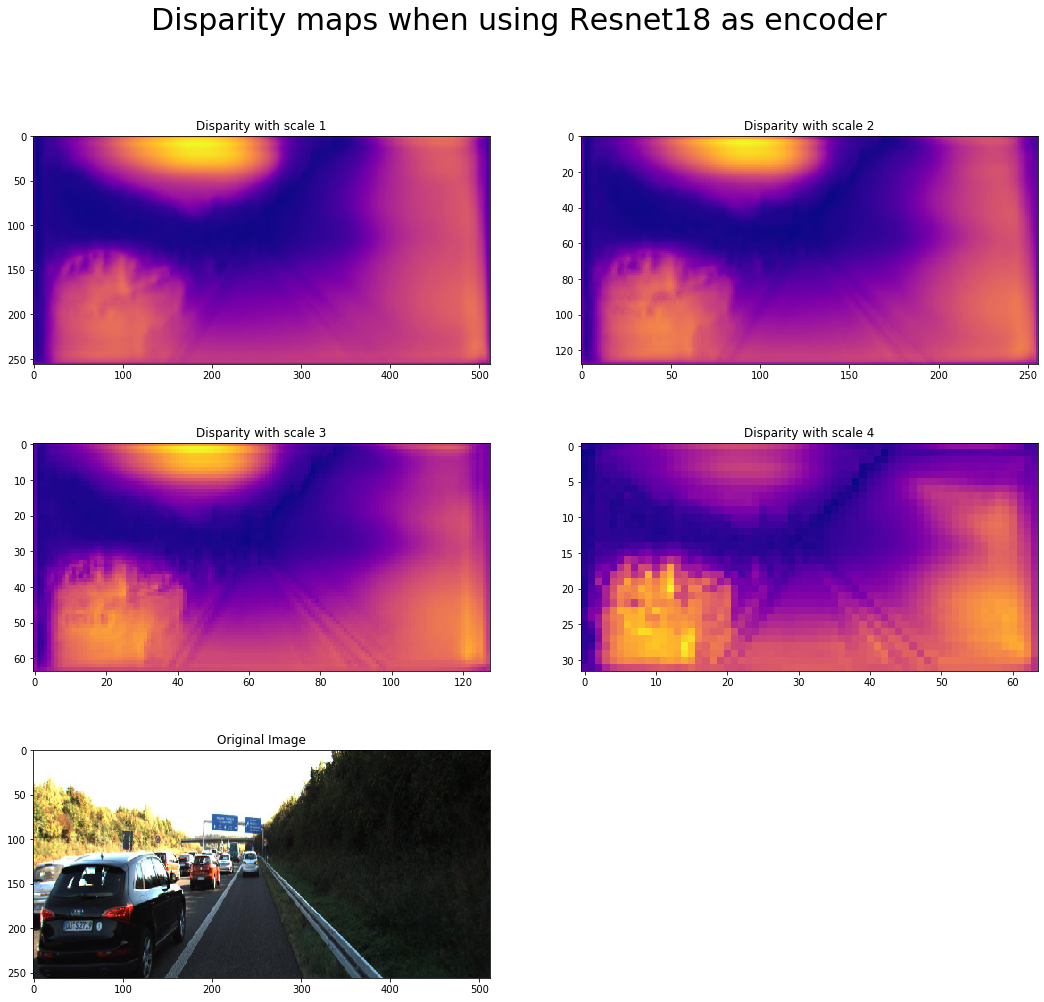

In [31]:
if (not use_pretrained_params):
    sample = sample.cpu()

plt.figure(2, figsize=(18, 16))
plt.suptitle("Disparity maps when using Resnet18 as encoder", fontsize=30)
plt.subplot(321)
plt.imshow(np.squeeze(np.array(disp1_Res.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 1")
plt.subplot(322)
plt.imshow(np.squeeze(np.array(disp2_Res.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 2")
plt.subplot(323)
plt.imshow(np.squeeze(np.array(disp3_Res.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 3")
plt.subplot(324)
plt.imshow(np.squeeze(np.array(disp4_Res.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 4")
plt.subplot(325)
plt.imshow(np.transpose(np.squeeze(np.array(sample)), axes=(1,2,0)))
plt.title("Original Image")
plt.show()

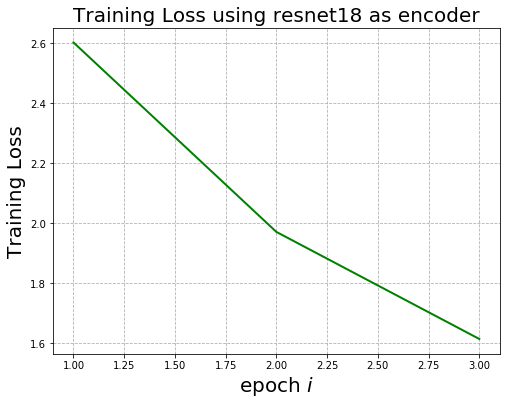

In [32]:
with open('train_historyRes.pickle', 'rb') as handle:
    data_Res = pickle.load(handle)
epoch = np.arange(epochs) + 1
fig = plt.figure(3, figsize=(8, 6))
plt.plot(epoch, data_Res["Train"], linewidth=2.0, color ="green")
plt.title("Training Loss using resnet18 as encoder", size = 20)
plt.xlabel("epoch $i$", fontsize=20)
plt.ylabel("Training Loss", fontsize=20)
plt.grid(linestyle='dashed')
plt.show()

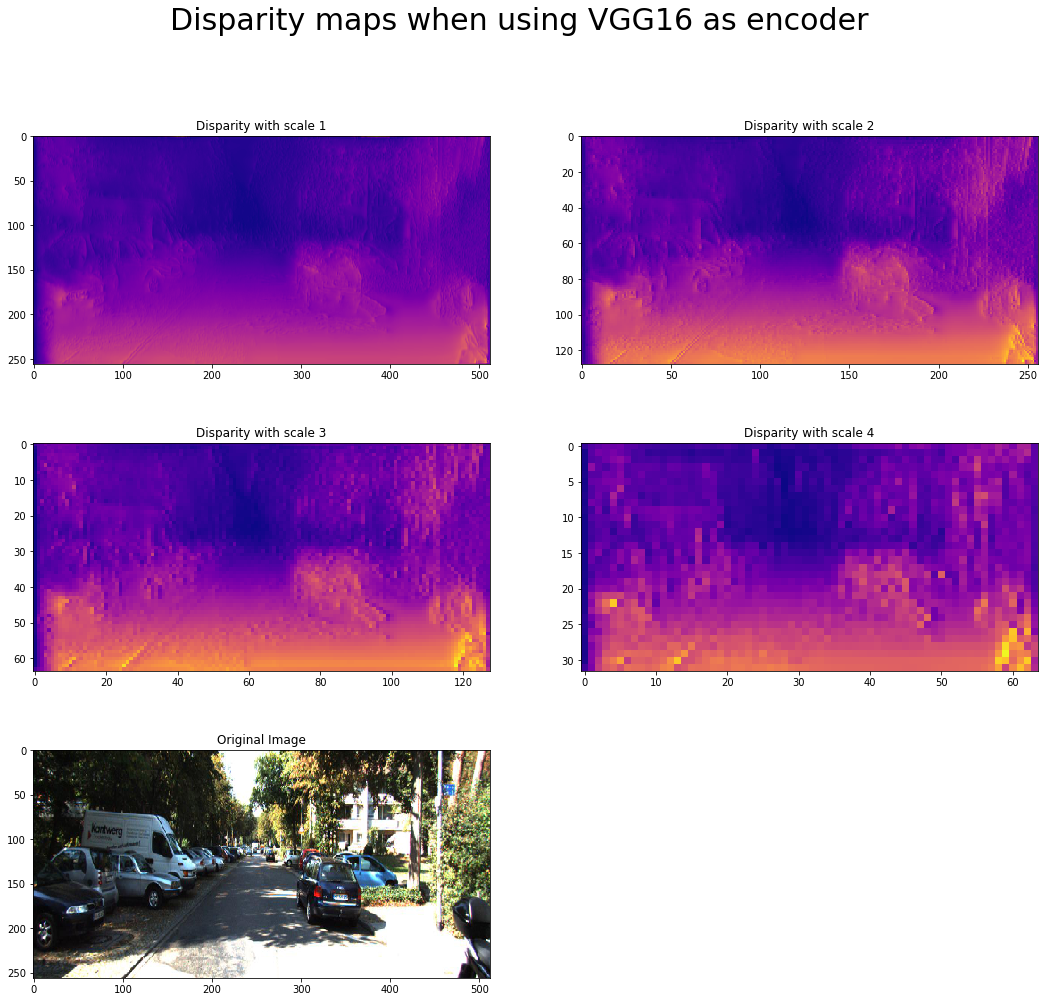

In [16]:
if (not use_pretrained_params):
    sample = sample.cpu()

plt.figure(4, figsize=(18, 16))
plt.suptitle("Disparity maps when using VGG16 as encoder", fontsize=30)
plt.subplot(321)
plt.imshow(np.squeeze(np.array(disp1_VGG.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 1")
plt.subplot(322)
plt.imshow(np.squeeze(np.array(disp2_VGG.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 2")
plt.subplot(323)
plt.imshow(np.squeeze(np.array(disp3_VGG.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 3")
plt.subplot(324)
plt.imshow(np.squeeze(np.array(disp4_VGG.cpu().detach().numpy()))[0], cmap="plasma")
plt.title("Disparity with scale 4")
plt.subplot(325)
plt.imshow(np.transpose(np.squeeze(np.array(sample)), axes=(1,2,0)))
plt.title("Original Image")
plt.show()

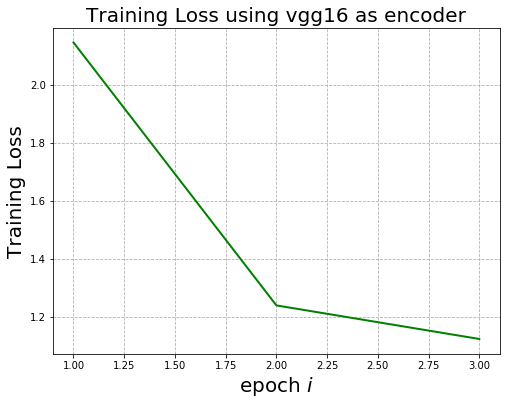

In [17]:
with open('train_historyVGG.pickle', 'rb') as handle:
    data_VGG = pickle.load(handle)
epoch = np.arange(epochs) + 1
fig = plt.figure(5, figsize=(8, 6))
plt.plot(epoch, data_VGG["Train"], linewidth=2.0, color ="green")
plt.title("Training Loss using vgg16 as encoder", size = 20)
plt.xlabel("epoch $i$", fontsize=20)
plt.ylabel("Training Loss", fontsize=20)
plt.grid(linestyle='dashed')
plt.show()

## 7) Conclusion section (2-4 paragraphs): summarizing your observations, results, etc.

## 8) References

### [1] Godard, C., Mac Aodha, O., Firman, M. and Gabriel, G. (2019). "Digging Into Self-Supervised Monocular Depth Estimation". Retrieved 13 December 2019, from https://arxiv.org/pdf/1806.01260.

### [2] Zhan, H., Weerasekera, C., Garg, R. and Reid, I. (2019). "Self-supervised Learning for Single View Depth and Surface Normal Estimation". Retrieved 13 December 2019, from https://arxiv.org/abs/1903.00112.

### [3] OniroAI, MonoDepth-PyTorch, (2018), GitHub repository, https://github.com/OniroAI/MonoDepth-PyTorch

### [4] Pillai, S., Ambrus, R. and Gaidon, A. (2018). SuperDepth: Self-Supervised, Super-Resolved Monocular Depth Estimation. Retrieved 13 December 2019, from https://arxiv.org/abs/1810.01849.

### [5] Godard, C., Mac Aodha, O., & Brostow, G. (2017). "Unsupervised Monocular Depth Estimation with Left-Right Consistency". Retrieved 13 December 2019, from https://arxiv.org/abs/1609.03677

### [6] Garg, R., Kumar, V., Carneiro, G. and Reid, I. (2016). "Unsupervised CNN for Single View Depth Estimation: Geometry to the Rescue". Retrieved 13 December 2019, from https://arxiv.org/pdf/1603.04992.